<a href="https://colab.research.google.com/github/JoaoMMS98/ML_2.0/blob/main/Notebooks/0.4367.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class='alert alert-block' style='background-color: #ffffff; border: 1px solid #333333; border-radius: 10px; padding: 20px; text-align: center;'> <h1 style='font-family: Arial, sans-serif; color: #000000; font-size: 36px;'>MACHINE LEARNING</h1> <h2 style='font-family: Arial, sans-serif; color: #333333; font-size: 28px;'>MDSAA-BA Program</h2> <hr style='border: 1px solid #555555;'> <h3 style='font-family: 'Open Sans', sans-serif; color: #666666; font-size: 24px;'>To Grant Or Not To Grant Project 2024/2025</h3> </div>

## Table of contents

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Importing the data](#2.-Importing-the-data)
3. [Exploring the data](#3.-Exploring-the-data)

## 1. Importing Libraries

In [1]:
!pip install bokeh

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

<br>

## 2. Importing the data

The `display.max_columns` option controls the number of columns to be printed. By setting the `display.max_columns` option to `None`, Pandas will display all columns in the DataFrame.

In [3]:
# Displays all columns of the dataset
pd.set_option('display.max_columns', None)

In [4]:
train = pd.read_csv('train_explored.csv', index_col=0) #../Data/
test = pd.read_csv('test_explored.csv', index_col=0) #../Data/

<br>

## 3. Model Selection

Hold out method

In this approach we randomly split the complete data into training and test sets. Then we perform the model training on the training set and use the validation set for validation purpose. 80% of the data will be used for training purposes, while 20% for validation.

We first split between independent and dependent variables.

In [5]:
x = train.drop(columns= 'Claim Injury Type')
y = train['Claim Injury Type']

In [6]:
train_set, val_set, y_train, y_val = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y
                                                   )

<br>

##### 4.1 Addressing the inconsistencies found

##### 4.1.1 `Accident Date`

In order to have the different components of the date (year, month and day), we are going to split the column `Accident Date` into three columns. We then proceed to remove the column from the datasets.

In [7]:
train_set['Accident Date'] = pd.to_datetime(train_set['Accident Date'])
val_set['Accident Date'] = pd.to_datetime(val_set['Accident Date'])
test['Accident Date'] = pd.to_datetime(test['Accident Date'])

In [8]:
train_set['Accident Year'] = train_set['Accident Date'].apply(lambda x: x.year)
val_set['Accident Year'] = val_set['Accident Date'].apply(lambda x: x.year)
test['Accident Year'] = test['Accident Date'].apply(lambda x: x.year)

In [9]:
train_set = train_set.drop(columns = 'Accident Date')
val_set = val_set.drop(columns = 'Accident Date')
test = test.drop(columns = 'Accident Date')

One aspect that is important to check is if the age at injury aligns with the difference between the accident date and the birth year. We had already seen that the feature `Age at Injury` has inconsistent values, therefore this mismatch might occur.

In [10]:
train_set.apply(lambda row: row['Accident Year'] - row['Birth Year'] == row['Age at Injury'], axis=1).value_counts()

,count
False,240703
True,218517


From the output above, we can see that in 21 8517 claims, there is a misalignment between the calculated age and the recorded age at the time of injury.

In [11]:
(train_set['Accident Year'] - train_set['Birth Year'] - train_set['Age at Injury']).value_counts()

,count
0.0,218517
1.0,194511
-1.0,241
119.0,67
118.0,6
120.0,2


The output above illustrates the differences in ages calculated from the `Accident Year`, `Birth Year`, and `Age at Injury`. Most differences are minor, with the majority falling within a 1-year difference. However, there are also significant anomalies where some records show a difference of more than 100 years. Also, there is some values that cannot be calculated due to missing values in some of these columns.

Given the inconsistencies and missing values in the date related data, these issues will be addressed. Since, some rows have mismatch between the calculated age and the recorded age at the time of injury we update the age based on the accident year and birth year

In [12]:
train_set[train_set['Birth Year'].isna() & train_set['Accident Year'].notna() & train_set['Age at Injury'].notna()].head()

,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Agreement Reached,Number of Dependents,Accident Year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,
5980545,31.0,N,2022-05-02,N,3.063832,NaN,2022-04-30,NaN,HEALTH & HOSPITAL CORP.,3A. SELF PUBLIC,BRONX,N,NYC,2023-01-09,F,0.0,62.0,IV,99.0,1.0,-9.0,10451,0.0,2.0,2022.0
5488794,31.0,N,2020-05-29,N,0.000000,NaN,2020-06-08,2020-05-20,STARR SPECIALTY INSURANCE,1A. PRIVATE,SUFFOLK,N,HAUPPAUGE,NaN,M,0.0,54.0,UK,45.0,52.0,34.0,34482,0.0,6.0,2019.0
5469588,33.0,N,2020-04-21,Y,3.213783,NaN,2020-05-21,2020-04-08,"POLICE, FIRE, SANITATION",3A. SELF PUBLIC,RICHMOND,N,NYC,2021-09-27,M,1.0,92.0,IV,27.0,10.0,31.0,10308,0.0,6.0,2020.0
5614437,25.0,N,2020-12-10,Y,3.132935,NaN,2020-12-18,2020-11-03,FEDERAL INSURANCE COMPANY,1A. PRIVATE,ERIE,N,BUFFALO,2021-03-09,M,1.0,71.0,UK,98.0,80.0,90.0,02370,0.0,6.0,2019.0
5458247,59.0,N,2020-03-24,N,0.000000,NaN,2020-03-24,NaN,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,WESTCHESTER,N,NYC,NaN,M,0.0,23.0,III,53.0,59.0,33.0,10587,0.0,3.0,2018.0


There are some rows, that eventhough there are no values in the feature `Birth Year`, we can find based on the values in `Age at Injury` and `Accident Year`.

In [13]:
train_set.loc[train_set['Birth Year'].isna() & train_set['Accident Year'].notna() & train_set['Age at Injury'].notna(), 'Birth Year'] = (
    train_set['Accident Year'] - train_set['Age at Injury'])

In [14]:
val_set.loc[val_set['Birth Year'].isna() & val_set['Accident Year'].notna() & val_set['Age at Injury'].notna(), 'Birth Year'] = (
    val_set['Accident Year'] - val_set['Age at Injury'])

Some rows have the same year in `Accident Year` and `Birth Year` and that is inconsistent. Based on that, the values in `Birth Year` will be replaced as missing.

In [15]:
train_set[train_set["Birth Year"] == train_set["Accident Year"]].head(5)

,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Agreement Reached,Number of Dependents,Accident Year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,
5721908,0.0,N,2021-05-14,N,0.0,2021.0,NaN,NaN,AMERICAN GUAR & LIAB INS CO,1A. PRIVATE,CHENANGO,N,BINGHAMTON,NaN,F,0.0,0.0,I,0.0,0.0,0.0,13815,0.0,5.0,2021.0
5578131,0.0,N,2020-10-15,N,0.0,2020.0,2020-08-14,NaN,"GENERAL MOTORS, LLC",4A. SELF PRIVATE,NIAGARA,N,BUFFALO,NaN,F,0.0,0.0,I,99.0,59.0,38.0,NaN,0.0,5.0,2020.0
5482425,0.0,N,2020-05-15,N,NaN,2020.0,NaN,NaN,STATE INSURANCE FUND,2A. SIF,DUTCHESS,N,ALBANY,NaN,F,0.0,61.0,II,0.0,0.0,0.0,12601,0.0,1.0,2020.0
5708974,0.0,N,2021-04-27,N,0.0,2021.0,2021-04-23,NaN,GREAT NECK UNION FREE,3A. SELF PUBLIC,NASSAU,N,NYC,NaN,F,0.0,0.0,IV,74.0,10.0,17.0,11021,0.0,5.0,2021.0
5564192,0.0,N,2020-09-23,Y,0.0,2020.0,NaN,2020-08-20,STATE INSURANCE FUND,2A. SIF,NEW YORK,N,NYC,NaN,F,0.0,62.0,IV,0.0,0.0,0.0,11356,0.0,2.0,2020.0


In [16]:
train_set.loc[train_set["Birth Year"] == train_set["Accident Year"], "Birth Year"] = np.nan

In [17]:
val_set.loc[val_set["Birth Year"] == val_set["Accident Year"], "Birth Year"] = np.nan

Since, some rows have the age at injury different from the difference between the birth year and the year of the accident, those will be updated.

In [18]:
train_set['Age at Injury'] = train_set['Accident Year'] - train_set['Birth Year']

In [19]:
val_set['Age at Injury'] = val_set['Accident Year'] - val_set['Birth Year']

In [20]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
import numpy as np

output_notebook()

cleaned_age = train_set['Age at Injury'].dropna()

hist, edges = np.histogram(cleaned_age, bins=40)

p = figure(title='Histogram of Age at Injury')

p.quad(
    top=hist,
    bottom=0,
    left=edges[:-1],
    right=edges[1:],
    fill_color='#FF8C00',
    line_color='black',
    line_width=1
)

# Display the plot in the notebook
show(p)

<br>

#### 4.1.2. `Zip Code`

As previously mentioned, there were some Zip codes that were inconsistent, therefore we will address them.

In [21]:
len(train_set["Zip Code"].unique())

9135

In [22]:
len(train_set[train_set["Zip Code"] == '10567'])

406

In [23]:
len(train_set[train_set["Zip Code"] == 10567.0])

0

The `fix_zip_code` function standardizes zip codes by converting any float values to integers and then back to strings. This ensures consistent formatting across all zip code entries.

In [24]:
def fix_zip_code(x):
    if isinstance(x, float) and x.is_integer():
        return str(int(x))[:5]
    if isinstance(x, str) and x.isnumeric():
        return str(int(x))[:5]
    try:
        return(str(int(x))[:5])
    except:
        warnings.warn("x cannot be turned into a string of 5 characters", UserWarning)

In [25]:
train_set['Zip Code'] = train_set['Zip Code'].apply(fix_zip_code)
val_set['Zip Code'] = val_set['Zip Code'].apply(fix_zip_code)

<ipython-input-24-5cbbda973fca>:9: UserWarning: x cannot be turned into a string of 5 characters
  warnings.warn("x cannot be turned into a string of 5 characters", UserWarning)


Checking if it worked.

In [26]:
len(train_set["Zip Code"].unique())

7304

In [27]:
len(train_set[train_set["Zip Code"] == '10567'])

406

In [28]:
len(train_set[train_set["Zip Code"] == 10567.0])

0

Now, the values for the `Zip Code` feature are standardized.

<br>

##### 4.2 Feature engineering

*Dummy Features*

To create binary indicators for whether each form was received, we'll define new columns: `Received_Employer_report` and `Received_employee_claim`. Each will be set to 1 if the corresponding date is present, and 0 if it's missing (already replaced with 0).

In [29]:
train_set["Received_C2"] = train_set["C-2 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
val_set["Received_C2"] = val_set["C-2 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
test["Received_C2"] = test["C-2 Date"].apply(lambda x: 0 if pd.isna(x) else 1)

In [30]:
train_set["Received_C3"] = train_set["C-3 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
val_set["Received_C3"] = val_set["C-3 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
test["Received_C3"] = test["C-3 Date"].apply(lambda x: 0 if pd.isna(x) else 1)

The same will be applied to indicate if a hearing was held. We'll create a new column, `Hearing_held`, set to 1 if the `First Hearing Date` happened and 0 if did not (already replaced with 0).

In [31]:
train_set["Hearing_held"] = train_set["First Hearing Date"].apply(lambda x: 0 if pd.isna(x) else 1)
val_set["Hearing_held"] = val_set["First Hearing Date"].apply(lambda x: 0 if pd.isna(x) else 1)
test["Hearing_held"] = test["First Hearing Date"].apply(lambda x: 0 if pd.isna(x) else 1)

<br>

*Categorical encoding*

In this step, we are going to encode some columns using the One Hot Encoder.

Some features that are binary categorical variables, like yes (Y) and no (N), we will convert it to 0 and 1. One of them will be discarded.

In [32]:
# Check columns in each dataframe
print("Train columns:", list(train_set.columns))
print("Validation columns:", list(val_set.columns))
print("Test columns:", list(test.columns))

Train columns: ['Age at Injury', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Agreement Reached', 'Number of Dependents', 'Accident Year', 'Received_C2', 'Received_C3', 'Hearing_held']
Validation columns: ['Age at Injury', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Co

In [33]:
train_set = pd.get_dummies(train_set, columns=['Attorney/Representative', 'COVID-19 Indicator','Alternative Dispute Resolution', 'Gender'], drop_first=True, dtype=int)
val_set = pd.get_dummies(val_set, columns=['Attorney/Representative', 'COVID-19 Indicator','Alternative Dispute Resolution', 'Gender'], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=['Attorney/Representative', 'COVID-19 Indicator','Alternative Dispute Resolution', 'Gender'], drop_first=True, dtype=int)

In [34]:
train_set.describe()

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents,Accident Year,Received_C2,Received_C3,Hearing_held,Attorney/Representative_Y,COVID-19 Indicator_Y,Alternative Dispute Resolution_U,Alternative Dispute Resolution_Y,Gender_M,Gender_U,Gender_X
count,454937.000000,436252.000000,457490.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,456261.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000
mean,42.954398,1.160236,1977.823749,0.742178,57.624263,52.915609,39.930595,38.592104,0.046470,3.003952,2020.828026,0.974762,0.325833,0.262556,0.316735,0.048116,0.000011,0.004503,0.584193,0.008144,0.000076
std,13.753604,1.474836,13.860449,1.924955,20.920515,27.006646,22.892690,23.053490,0.210501,2.000465,1.856728,0.156849,0.468686,0.440024,0.465204,0.214012,0.003300,0.066955,0.492861,0.089877,0.008730
min,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,0.000000,0.000000,1961.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1966.000000,0.000000,44.000000,29.000000,10.000000,32.000000,0.000000,1.000000,2020.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,0.000000,1978.000000,0.000000,61.000000,56.000000,49.000000,38.000000,0.000000,3.000000,2021.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,54.000000,2.926517,1989.000000,0.000000,62.000000,75.000000,52.000000,53.000000,0.000000,5.000000,2022.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,120.000000,6.451492,2018.000000,73.000000,92.000000,99.000000,91.000000,99.000000,1.000000,6.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
print(train_set['Attorney/Representative_Y'].unique())

[1 0]


<br>Defining the columns to encode.

In [36]:
# train_set.drop(columns='Alternative Dispute Resolution_U', inplace=True)
# val_set.drop(columns='Alternative Dispute Resolution_U', inplace=True)
# test.drop(columns='Alternative Dispute Resolution_U', inplace=True)

In [37]:
train_set.drop(columns='Gender_U', inplace=True, errors='ignore')
val_set.drop(columns='Gender_U', inplace=True, errors='ignore')
test.drop(columns='Gender_U', inplace=True, errors='ignore')
train_set.drop(columns='Gender_X', inplace=True, errors='ignore')
val_set.drop(columns='Gender_X', inplace=True, errors='ignore')
test.drop(columns='Gender_X', inplace=True, errors='ignore')

In [38]:
# columns_to_encode = []#'Alternative Dispute Resolution', 'Gender'

Initializing the encoder and fitting it on the training set. This encoder will learns the unique categories present in the training set.

In [39]:
# encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoded = encoder.fit(train_set[columns_to_encode])

Transforming the `train_set`, `val_set`, and `test_set` with the fitted encoder. This ensures that the columns are encoded consistently across all sets.

In [40]:
# train_encoded = encoder.transform(train_set[columns_to_encode])
# validation_encoded = encoder.transform(val_set[columns_to_encode])
# test_encoded = encoder.transform(test[columns_to_encode])

Converting the arrays into DataFrames with the appropriate column names.

In [41]:
# train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=train_set.index)
# validation_encoded_df = pd.DataFrame(validation_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=val_set.index)
# test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=test.index)

Dropping the original columns.

In [42]:
# train_set.drop(columns=columns_to_encode, inplace=True)
# train_set = pd.concat([train_set, train_encoded_df], axis=1)

In [43]:
# val_set.drop(columns=columns_to_encode, inplace=True)
# val_set = pd.concat([val_set, validation_encoded_df], axis=1)

In [44]:
# test.drop(columns=columns_to_encode, inplace=True)
# test = pd.concat([test, test_encoded_df], axis=1)

Dropping the features `Alternative Dispute Resolution_U` and `Gender_X`, in order to avoid multicollinearity.

In [45]:
train_set

,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Agreement Reached,Number of Dependents,Accident Year,Received_C2,Received_C3,Hearing_held,Attorney/Representative_Y,COVID-19 Indicator_Y,Alternative Dispute Resolution_U,Alternative Dispute Resolution_Y,Gender_M
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5785935,50.0,2021-08-10,2.872191,1971.0,2021-08-10,2021-08-30,PROPERTY AND CASUALTY,1A. PRIVATE,QUEENS,NYC,NaN,2.0,31.0,IV,29.0,59.0,42.0,11432,0.0,6.0,2021.0,1,1,0,1,0,0,0,0
5980545,31.0,2022-05-02,3.063832,1991.0,2022-04-30,NaN,HEALTH & HOSPITAL CORP.,3A. SELF PUBLIC,BRONX,NYC,2023-01-09,0.0,62.0,IV,99.0,1.0,-9.0,10451,0.0,2.0,2022.0,1,0,1,0,0,0,0,0
5552635,44.0,2020-09-04,0.000000,1976.0,2020-09-04,NaN,AMERICAN ZURICH INSURANCE CO,1A. PRIVATE,KINGS,NYC,NaN,0.0,49.0,IV,80.0,52.0,56.0,11203,0.0,3.0,2020.0,1,0,0,0,0,0,0,1
5758039,25.0,2021-07-02,0.000000,1996.0,2021-07-02,NaN,"NORDSTROM, INC.",4A. SELF PRIVATE,KINGS,NYC,NaN,0.0,44.0,IV,68.0,10.0,11.0,11237,0.0,1.0,2021.0,1,0,0,0,0,0,0,1
5951382,42.0,2022-03-25,2.399674,1980.0,2022-03-30,2022-03-15,NEW YORK BLACK CAR OPERATORS',4A. SELF PRIVATE,NASSAU,NYC,2022-12-28,0.0,48.0,IV,45.0,49.0,-9.0,11003,0.0,4.0,2022.0,1,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837651,26.0,2021-10-19,3.095365,1995.0,2021-10-19,2021-11-10,INDEMNITY INSURANCE CO OF,1A. PRIVATE,WESTCHESTER,NYC,2022-01-24,1.0,62.0,III,98.0,80.0,41.0,10805,0.0,6.0,2021.0,1,1,1,1,0,0,0,1
5781926,55.0,2021-08-04,2.986888,1966.0,2021-08-04,2021-08-19,REDWOOD FIRE & CASUALTY,1A. PRIVATE,QUEENS,NYC,2022-03-07,7.0,62.0,IV,74.0,10.0,90.0,11429,0.0,1.0,2021.0,1,1,1,1,0,0,0,1
5890060,57.0,2022-01-04,2.900416,1964.0,2022-01-04,NaN,UTICA MUTUAL INS CO,1A. PRIVATE,ERIE,BUFFALO,NaN,0.0,81.0,I,53.0,52.0,53.0,14127,0.0,5.0,2021.0,1,0,0,0,0,0,0,0


<br>

Frequency encoding

`Industry Code`

In [46]:
frequency_map_ic = train_set['Industry Code'].value_counts(normalize=False)

In [47]:
train_set['Industry Code'] = train_set['Industry Code'].map(frequency_map_ic)
val_set['Industry Code'] = val_set['Industry Code'].map(frequency_map_ic)
test['Industry Code'] = test['Industry Code'].map(frequency_map_ic)

<br>

`WCIO Cause of Injury Code`

In [48]:
frequency_map_wcio_ic = train_set['WCIO Cause of Injury Code'].value_counts(normalize=False)

In [49]:
train_set['WCIO Cause of Injury Code'] = train_set['WCIO Cause of Injury Code'].map(frequency_map_wcio_ic)
val_set['WCIO Cause of Injury Code'] = val_set['WCIO Cause of Injury Code'].map(frequency_map_wcio_ic)
test['WCIO Cause of Injury Code'] = test['WCIO Cause of Injury Code'].map(frequency_map_wcio_ic)

<br>

`WCIO Nature of Injury Code`

In [50]:
frequency_map_wcio_nic = train_set['WCIO Nature of Injury Code'].value_counts(normalize=False)

In [51]:
train_set['WCIO Nature of Injury Code'] = train_set['WCIO Nature of Injury Code'].map(frequency_map_wcio_nic)
val_set['WCIO Nature of Injury Code'] = val_set['WCIO Nature of Injury Code'].map(frequency_map_wcio_nic)
test['WCIO Nature of Injury Code'] = test['WCIO Nature of Injury Code'].map(frequency_map_wcio_nic)

<br>

`WCIO Part Of Body Code`

In [52]:
frequency_map_wcio_pbc = train_set['WCIO Part Of Body Code'].value_counts(normalize=False)

In [53]:
train_set['WCIO Part Of Body Code'] = train_set['WCIO Part Of Body Code'].map(frequency_map_wcio_pbc)
val_set['WCIO Part Of Body Code'] = val_set['WCIO Part Of Body Code'].map(frequency_map_wcio_pbc)
test['WCIO Part Of Body Code'] = test['WCIO Part Of Body Code'].map(frequency_map_wcio_pbc)

<br>

`Medical Fee Region`

In [54]:
frequency_map_mfr = train_set['Medical Fee Region'].value_counts(normalize=False)

In [55]:
train_set['Medical Fee Region'] = train_set['Medical Fee Region'].map(frequency_map_mfr)
val_set['Medical Fee Region'] = val_set['Medical Fee Region'].map(frequency_map_mfr)
test['Medical Fee Region'] = test['Medical Fee Region'].map(frequency_map_mfr)

<br>

`Carrier Type`

In [56]:
frequency_map_ct = train_set['Carrier Type'].value_counts(normalize=False)
frequency_map_cn = train_set['Carrier Name'].value_counts(normalize=False)
frequency_map_coi = train_set['County of Injury'].value_counts(normalize=False)
frequency_map_dn = train_set['District Name'].value_counts(normalize=False)

In [57]:
train_set['Carrier Type'] = train_set['Carrier Type'].map(frequency_map_ct)
val_set['Carrier Type'] = val_set['Carrier Type'].map(frequency_map_ct)
test['Carrier Type'] = test['Carrier Type'].map(frequency_map_ct)

In [58]:
train_set['Carrier Name'] = train_set['Carrier Name'].map(frequency_map_cn)
val_set['Carrier Name'] = val_set['Carrier Name'].map(frequency_map_cn)
test['Carrier Name'] = test['Carrier Name'].map(frequency_map_cn)

In [59]:
train_set['County of Injury'] = train_set['County of Injury'].map(frequency_map_coi)
val_set['County of Injury'] = val_set['County of Injury'].map(frequency_map_coi)
test['County of Injury'] = test['County of Injury'].map(frequency_map_coi)

In [60]:
train_set['District Name'] = train_set['District Name'].map(frequency_map_dn)
val_set['District Name'] = val_set['District Name'].map(frequency_map_dn)
test['District Name'] = test['District Name'].map(frequency_map_dn)

In [61]:
train_set

,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Agreement Reached,Number of Dependents,Accident Year,Received_C2,Received_C3,Hearing_held,Attorney/Representative_Y,COVID-19 Indicator_Y,Alternative Dispute Resolution_U,Alternative Dispute Resolution_Y,Gender_M
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5785935,50.0,2021-08-10,2.872191,1971.0,2021-08-10,2021-08-30,1755,228484,46591,216769,NaN,2.0,8081,212791,23478,28947,41386,11432,0.0,6.0,2021.0,1,1,0,1,0,0,0,0
5980545,31.0,2022-05-02,3.063832,1991.0,2022-04-30,NaN,4478,97437,31683,216769,2023-01-09,0.0,91422,212791,18015,4764,33580,10451,0.0,2.0,2022.0,1,0,1,0,0,0,0,0
5552635,44.0,2020-09-04,0.000000,1976.0,2020-09-04,NaN,14020,228484,42673,216769,NaN,0.0,13421,212791,2585,122836,15030,11203,0.0,3.0,2020.0,1,0,0,0,0,0,0,1
5758039,25.0,2021-07-02,0.000000,1996.0,2021-07-02,NaN,94,42176,42673,216769,NaN,0.0,34875,212791,8654,88310,6312,11237,0.0,1.0,2021.0,1,0,0,0,0,0,0,1
5951382,42.0,2022-03-25,2.399674,1980.0,2022-03-30,2022-03-15,5841,42176,34872,216769,2022-12-28,0.0,29878,212791,13351,44593,33580,11003,0.0,4.0,2022.0,1,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837651,26.0,2021-10-19,3.095365,1995.0,2021-10-19,2021-11-10,7248,228484,20630,216769,2022-01-24,1.0,91422,43043,3511,2257,6524,10805,0.0,6.0,2021.0,1,1,1,1,0,0,0,1
5781926,55.0,2021-08-04,2.986888,1966.0,2021-08-04,2021-08-19,350,228484,46591,216769,2022-03-07,7.0,91422,212791,29667,88310,18167,11429,0.0,1.0,2021.0,1,1,1,1,0,0,0,1
5890060,57.0,2022-01-04,2.900416,1964.0,2022-01-04,NaN,309,228484,24655,36490,NaN,0.0,10580,108512,9519,122836,38473,14127,0.0,5.0,2021.0,1,0,0,0,0,0,0,0


<br>

*Encoding the target feature*

Given that the target variable is ordinal and categorical, we are going to encode it.

In [62]:
  # injury_type_mapping = {
  #     '1. CANCELLED': 1,
  #     '2. NON-COMP': 2,
  #     '3. MED ONLY': 3,
  #     '4. TEMPORARY': 4,
  #     '5. PPD SCH LOSS': 5,
  #     '6. PPD NSL': 6,
  #     '7. PTD': 7,
  #     '8. DEATH': 8
  # }

In [63]:
# y_train_encoded = y_train.map(injury_type_mapping)
# y_val_encoded = y_val.map(injury_type_mapping)

<br>

#### 4.3 Checking Outliers

In [64]:
"""# Set up the matplotlib figure
plt.figure(figsize=(15, 8))

# Create a grid of subplots for numeric columns
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=train_set[column], color='steelblue')
    plt.title(column)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()"""

"# Set up the matplotlib figure\nplt.figure(figsize=(15, 8))\n\n# Create a grid of subplots for numeric columns\nfor i, column in enumerate(numeric_columns, 1):\n    plt.subplot(4, 4, i)\n    sns.boxplot(data=train_set[column], color='steelblue')\n    plt.title(column)\n\n# Adjust layout to prevent overlap\nplt.tight_layout()\n\n# Show the plot\nplt.show()"

Given the presence of outliers in some features, we will apply capping to mitigate their influence. This will be achieved by scaling the `train_set` using the Robust Scaler, which is less sensitive to outliers and ensures that the scaling is based on the interquartile range (IQR) rather than the mean and standard deviation.

<br>

#### 3.4 Filling the missing values

As noticed the data has some missing data, therefore we will fill the missing values with the median and mode for numerical and categorical features, respectively.

In [65]:
train_set.isna().sum()

,0
Age at Injury,4283
Assembly Date,0
Average Weekly Wage,22968
Birth Year,1730
C-2 Date,11590
C-3 Date,309591
Carrier Name,0
Carrier Type,0
County of Injury,0
District Name,0


In [66]:
col_fill_median = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Accident Year']

In [67]:
for col in col_fill_median:
    median_value = train_set[col].median()

    train_set[col].fillna(median_value, inplace=True)
    val_set[col].fillna(median_value, inplace=True)
    test[col].fillna(median_value, inplace=True)

<ipython-input-67-158c7c73ae0d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set[col].fillna(median_value, inplace=True)
<ipython-input-67-158c7c73ae0d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [68]:
col_fill_mode = ['C-2 Date', 'C-3 Date', 'First Hearing Date', 'Zip Code']

In [69]:
for col in col_fill_mode:
    mode_value = train_set[col].mode()[0]

    train_set[col].fillna(mode_value, inplace=True)
    val_set[col].fillna(mode_value, inplace=True)
    test[col].fillna(mode_value, inplace=True)

<ipython-input-69-b0f0ceab1d80>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set[col].fillna(mode_value, inplace=True)
<ipython-input-69-b0f0ceab1d80>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

<br>

#### 3.4 Feature Scaling

Before applying the scaler is necessary to first split the `train_set`, `val_set` and `test` into a numerical and categorical set. In this way, we can apply the scaler in the numerical features.

In [70]:
import pandas as pd

def calculate_days_until_reference(df, reference_date='2023-12-25'):
    reference_date = pd.to_datetime(reference_date)
    date_columns = ['Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
        df[col] = (reference_date - df[col]).dt.days

    return df

train_set = calculate_days_until_reference(train_set)
val_set = calculate_days_until_reference(val_set)
test = calculate_days_until_reference(test)

In [71]:
train_set.describe()

,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents,Accident Year,Received_C2,Received_C3,Hearing_held,Attorney/Representative_Y,COVID-19 Indicator_Y,Alternative Dispute Resolution_U,Alternative Dispute Resolution_Y,Gender_M
count,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000
mean,42.945497,888.217896,1.102206,1977.824413,892.852661,1240.355154,21062.544867,155437.581826,25242.984400,126385.037320,626.015160,0.742178,43172.569365,139916.868634,16058.118113,62324.228827,20328.935887,0.046470,3.003952,2020.829134,0.974762,0.325833,0.262556,0.316735,0.048116,0.000011,0.004503,0.584193
std,13.689623,314.994142,1.459558,13.834320,402.607187,312.322855,33546.386356,74299.255895,16749.092402,86338.021594,186.906101,1.924955,31868.781553,71326.888684,10547.545722,45408.992627,13013.078754,0.210501,2.000465,1.850788,0.156849,0.468686,0.440024,0.465204,0.214012,0.003300,0.066955,0.492861
min,2.000000,359.000000,0.000000,1900.000000,-158.000000,-158.000000,1.000000,2.000000,109.000000,3189.000000,-165.000000,0.000000,290.000000,26888.000000,11.000000,1.000000,40.000000,0.000000,0.000000,1961.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,614.000000,0.000000,1967.000000,614.000000,1173.000000,812.000000,88880.000000,9170.000000,36490.000000,619.000000,0.000000,13823.000000,67986.000000,8105.000000,18247.000000,8978.000000,0.000000,1.000000,2020.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,878.000000,0.000000,1978.000000,882.000000,1414.000000,4478.000000,97437.000000,24030.000000,68742.000000,619.000000,0.000000,34875.000000,108512.000000,13351.000000,44593.000000,18167.000000,0.000000,3.000000,2021.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,54.000000,1154.000000,2.902586,1989.000000,1137.000000,1414.000000,14020.000000,228484.000000,42673.000000,216769.000000,619.000000,0.000000,73715.000000,212791.000000,25481.000000,122836.000000,30179.000000,0.000000,5.000000,2022.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,120.000000,1454.000000,6.451492,2018.000000,10209.000000,11364.000000,88880.000000,228484.000000,48473.000000,216769.000000,1425.000000,73.000000,91422.000000,212791.000000,37257.000000,122836.000000,41386.000000,1.000000,6.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
train_numerical = train_set.select_dtypes(include='number')
train_categorical = train_set.select_dtypes(include='object')

In [73]:
train_numerical.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age at Injury,459220.0,42.945497,13.689623,2.0,31.0,42.0,54.000000,120.000000
Assembly Date,459220.0,888.217896,314.994142,359.0,614.0,878.0,1154.000000,1454.000000
Average Weekly Wage,459220.0,1.102206,1.459558,0.0,0.0,0.0,2.902586,6.451492
Birth Year,459220.0,1977.824413,13.834320,1900.0,1967.0,1978.0,1989.000000,2018.000000
C-2 Date,459220.0,892.852661,402.607187,-158.0,614.0,882.0,1137.000000,10209.000000
C-3 Date,459220.0,1240.355154,312.322855,-158.0,1173.0,1414.0,1414.000000,11364.000000
Carrier Name,459220.0,21062.544867,33546.386356,1.0,812.0,4478.0,14020.000000,88880.000000
Carrier Type,459220.0,155437.581826,74299.255895,2.0,88880.0,97437.0,228484.000000,228484.000000
County of Injury,459220.0,25242.984400,16749.092402,109.0,9170.0,24030.0,42673.000000,48473.000000
District Name,459220.0,126385.037320,86338.021594,3189.0,36490.0,68742.0,216769.000000,216769.000000



=== DETAILED OUTLIER ANALYSIS REPORT ===


COLUMN: Age at Injury

1. BASIC STATISTICS:
********************
Mean: 42.95
Median: 42.00
Standard Deviation: 13.69
Range: [2.00, 120.00]
IQR: 23.00 (Q1: 31.00, Q3: 54.00)

2. DISTRIBUTION CHARACTERISTICS:
********************
Skewness: 0.17
Kurtosis: -0.69

3. OUTLIER DETECTION:
********************

IQR Method:
- Count: 249
- Percentage: 0.05%
- Bounds: [-3.50, 88.50]

Z-Score Method (>3 std):
- Count: 374
- Percentage: 0.08%

Modified Z-Score Method:
- Count: 121
- Percentage: 0.03%

4. EXTREME VALUES:
********************

Top 10 Highest Values:
1. Index 5494968: 120.00
2. Index 6142340: 120.00
3. Index 5796721: 119.00
4. Index 5601634: 119.00
5. Index 5525175: 119.00
6. Index 5406866: 119.00
7. Index 5794400: 119.00
8. Index 5789190: 119.00
9. Index 5758491: 119.00
10. Index 6130028: 119.00

Bottom 10 Lowest Values:
1. Index 5412625: 2.00
2. Index 5412736: 2.00
3. Index 5453057: 5.00
4. Index 5821685: 7.00
5. Index 6127974: 7.00
6. Inde

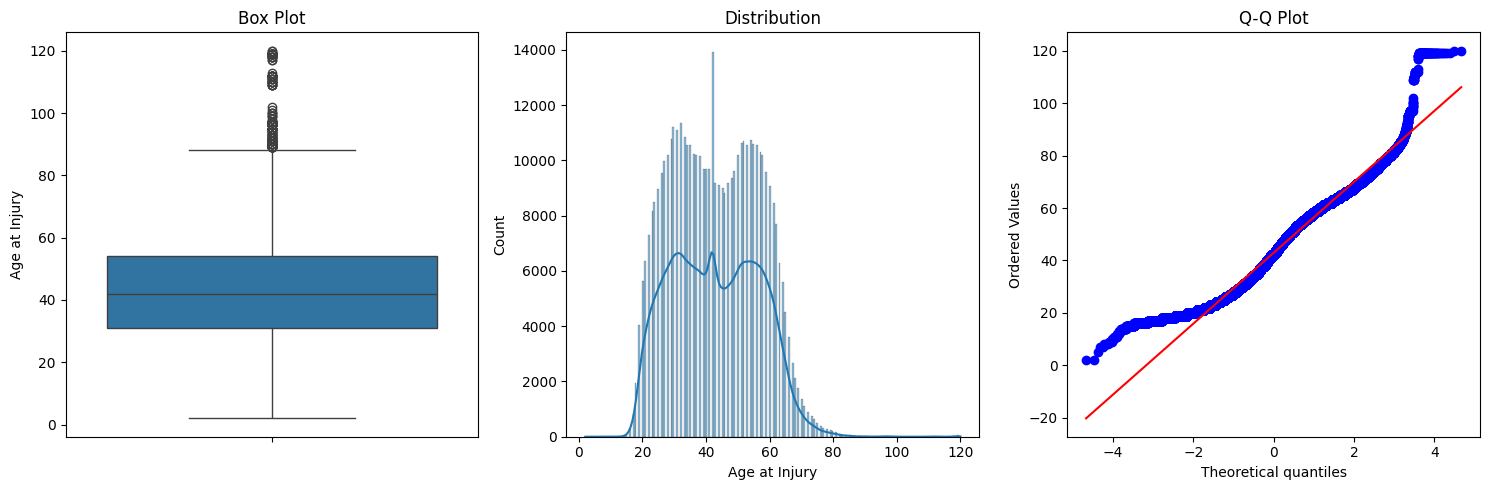


Visualizations for Assembly Date


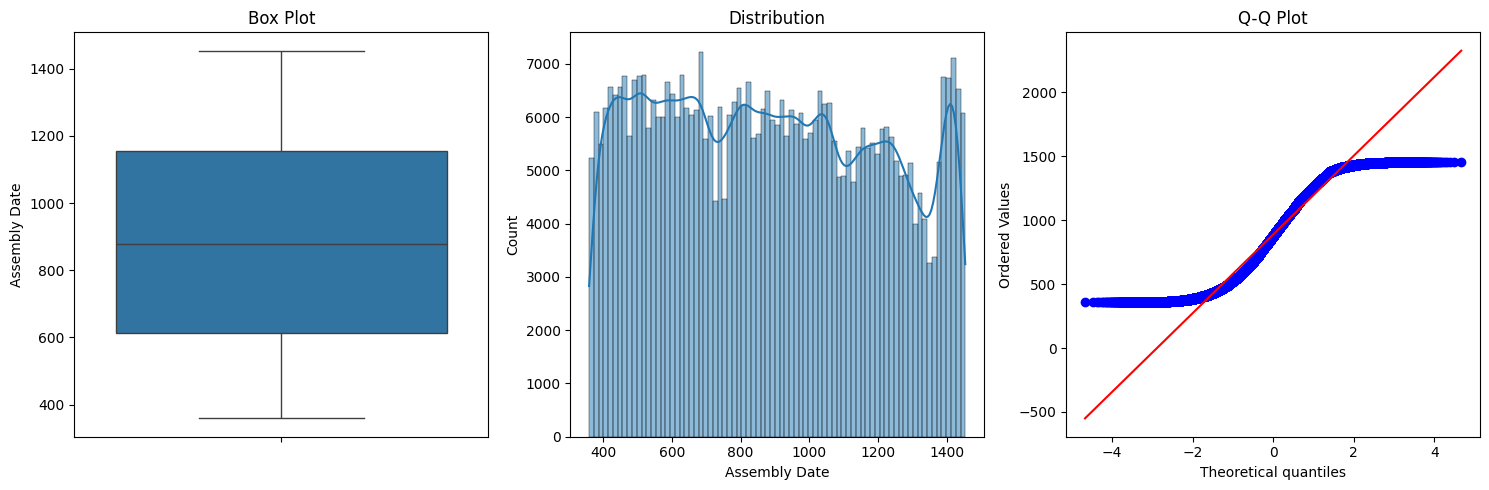


Visualizations for Average Weekly Wage


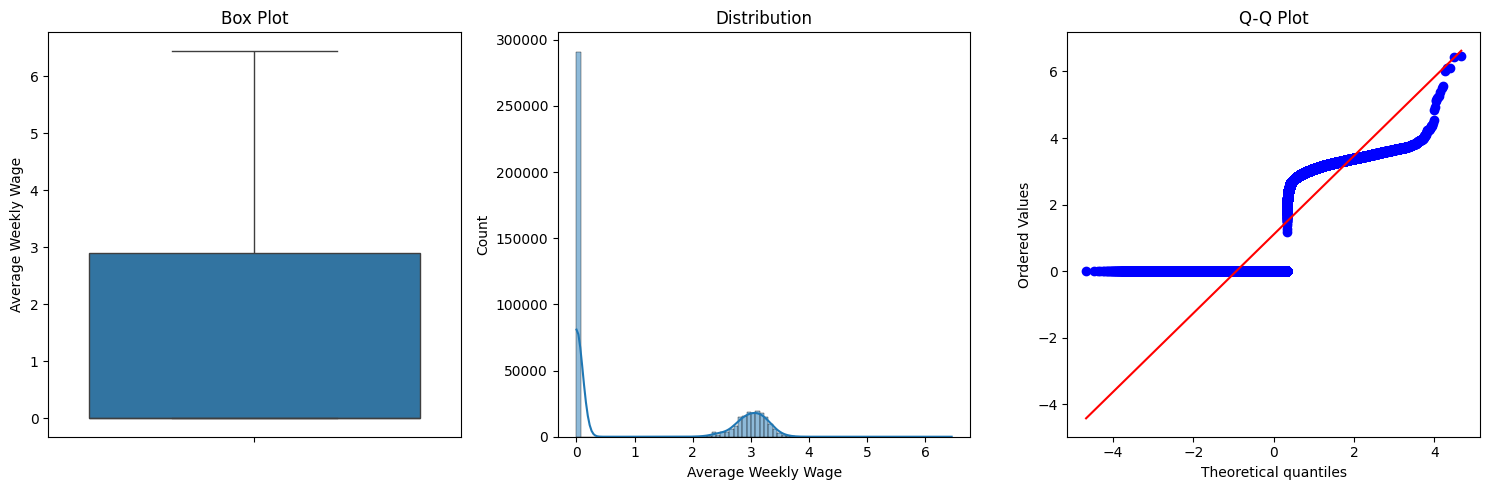


Visualizations for Birth Year


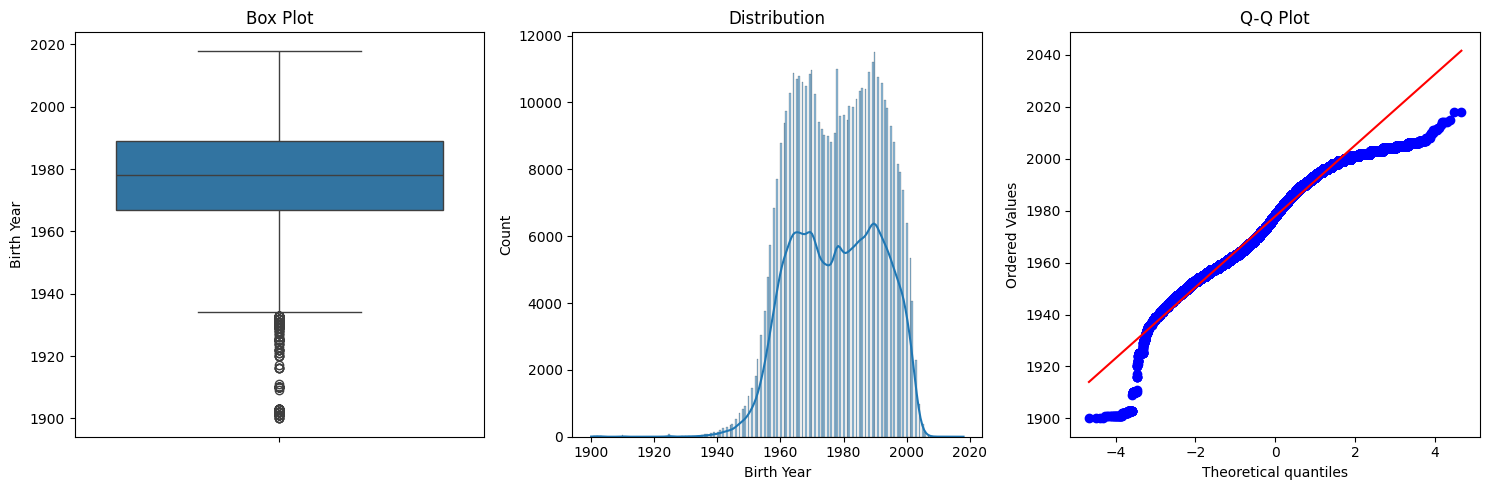


Visualizations for C-2 Date


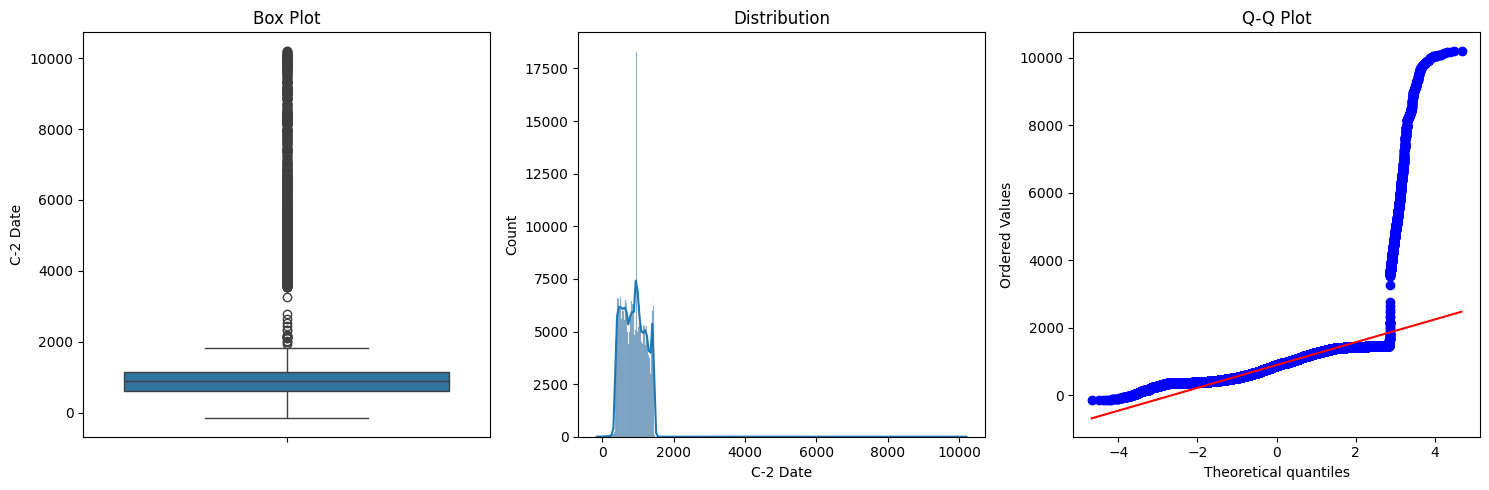


Visualizations for C-3 Date


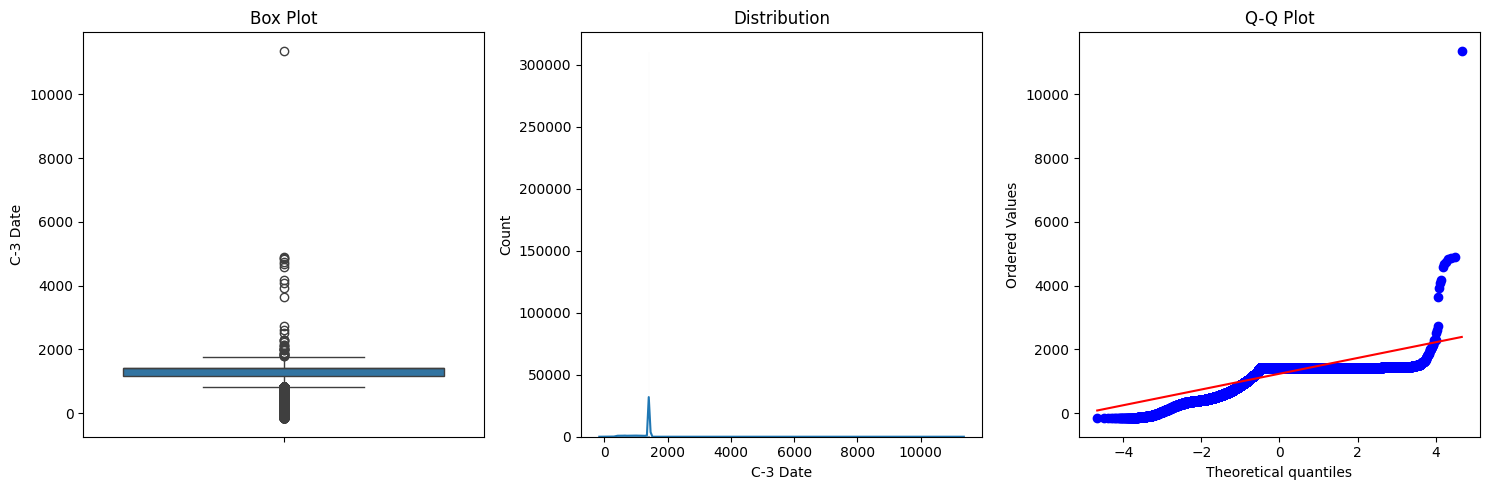


Visualizations for Carrier Name


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_outliers(df, exclude_columns=None):
    """
    Generate detailed outlier analysis report for numeric columns

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    exclude_columns (list): Columns to exclude from analysis
    """
    # Initialize results dictionary
    results = {}

    # Get numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if exclude_columns:
        numeric_cols = [col for col in numeric_cols if col not in exclude_columns]

    for column in numeric_cols:
        # Basic statistics
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate z-scores
        z_scores = np.abs(stats.zscore(df[column], nan_policy='omit'))

        # Calculate modified z-scores
        median = df[column].median()
        mad = stats.median_abs_deviation(df[column], nan_policy='omit')
        modified_z_scores = np.abs(0.6745 * (df[column] - median) / mad)

        # Identify outliers using different methods
        iqr_outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        z_score_outliers = z_scores > 3
        modified_z_outliers = modified_z_scores > 3.5

        # Get extreme values
        outlier_values = df[column][iqr_outliers].values

        results[column] = {
            'basic_stats': {
                'mean': df[column].mean(),
                'median': df[column].median(),
                'std': df[column].std(),
                'min': df[column].min(),
                'max': df[column].max(),
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR
            },
            'outliers': {
                'IQR_method': {
                    'count': iqr_outliers.sum(),
                    'percentage': (iqr_outliers.sum() / len(df)) * 100,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                },
                'Z_score': {
                    'count': z_score_outliers.sum(),
                    'percentage': (z_score_outliers.sum() / len(df)) * 100
                },
                'Modified_Z': {
                    'count': modified_z_outliers.sum(),
                    'percentage': (modified_z_outliers.sum() / len(df)) * 100
                }
            },
            'extreme_values': {
                'top_10': df[column].nlargest(10).to_dict(),
                'bottom_10': df[column].nsmallest(10).to_dict(),
                'outlier_summary': {
                    'count': len(outlier_values),
                    'unique_values': np.unique(outlier_values).tolist()[:10]  # First 10 unique outliers
                }
            }
        }

        # Add skewness and kurtosis
        results[column]['distribution'] = {
            'skewness': stats.skew(df[column].dropna()),
            'kurtosis': stats.kurtosis(df[column].dropna())
        }

    return results

def print_outlier_report(results):
    """Print formatted outlier analysis results"""
    print("\n=== DETAILED OUTLIER ANALYSIS REPORT ===\n")

    for column, stats in results.items():
        print(f"\n{'='*80}")
        print(f"COLUMN: {column}")
        print(f"{'='*80}")

        # Basic Statistics
        print("\n1. BASIC STATISTICS:")
        print(f"{'*'*20}")
        basic = stats['basic_stats']
        print(f"Mean: {basic['mean']:.2f}")
        print(f"Median: {basic['median']:.2f}")
        print(f"Standard Deviation: {basic['std']:.2f}")
        print(f"Range: [{basic['min']:.2f}, {basic['max']:.2f}]")
        print(f"IQR: {basic['IQR']:.2f} (Q1: {basic['Q1']:.2f}, Q3: {basic['Q3']:.2f})")

        # Distribution Characteristics
        print("\n2. DISTRIBUTION CHARACTERISTICS:")
        print(f"{'*'*20}")
        dist = stats['distribution']
        print(f"Skewness: {dist['skewness']:.2f}")
        print(f"Kurtosis: {dist['kurtosis']:.2f}")

        # Outlier Detection Results
        print("\n3. OUTLIER DETECTION:")
        print(f"{'*'*20}")
        out = stats['outliers']

        print("\nIQR Method:")
        print(f"- Count: {out['IQR_method']['count']}")
        print(f"- Percentage: {out['IQR_method']['percentage']:.2f}%")
        print(f"- Bounds: [{out['IQR_method']['lower_bound']:.2f}, {out['IQR_method']['upper_bound']:.2f}]")

        print("\nZ-Score Method (>3 std):")
        print(f"- Count: {out['Z_score']['count']}")
        print(f"- Percentage: {out['Z_score']['percentage']:.2f}%")

        print("\nModified Z-Score Method:")
        print(f"- Count: {out['Modified_Z']['count']}")
        print(f"- Percentage: {out['Modified_Z']['percentage']:.2f}%")

        # Extreme Values
        print("\n4. EXTREME VALUES:")
        print(f"{'*'*20}")
        ext = stats['extreme_values']

        print("\nTop 10 Highest Values:")
        for i, (idx, val) in enumerate(ext['top_10'].items(), 1):
            print(f"{i}. Index {idx}: {val:.2f}")

        print("\nBottom 10 Lowest Values:")
        for i, (idx, val) in enumerate(ext['bottom_10'].items(), 1):
            print(f"{i}. Index {idx}: {val:.2f}")

        print("\n")

# Execute the analysis
# Exclude binary and categorical columns
exclude_cols = ['Received_C2', 'Received_C3', 'Hearing_held', 'Gender_M',
                'Attorney/Representative_Y', 'COVID-19_Indicator_Y',
                'Alternative_Dispute_Resolution_U', 'Alternative_Dispute_Resolution_Y']

# Run analysis
outlier_results = analyze_outliers(train_numerical, exclude_columns=exclude_cols)

# Print report
print_outlier_report(outlier_results)

# Optional: Create visualizations for each numeric column
def plot_outlier_analysis(train_numerical, column):
    plt.figure(figsize=(15, 5))

    # Box plot
    plt.subplot(131)
    sns.boxplot(y=train_numerical[column])
    plt.title('Box Plot')

    # Histogram with KDE
    plt.subplot(132)
    sns.histplot(train_numerical[column], kde=True)
    plt.title('Distribution')

    # QQ plot
    plt.subplot(133)
    stats.probplot(train_numerical[column], dist="norm", plot=plt)
    plt.title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

# Create plots for each numeric column
for column in outlier_results.keys():
    print(f"\nVisualizations for {column}")
    plot_outlier_analysis(train_numerical, column)

In [ ]:
def handle_outliers(df):
    df_clean = df.copy()
    modifications = {}

    # Track modifications for each column
    for col in df_clean.columns:
        modifications[col] = {
            'original_count': len(df_clean),
            'modified_count': 0,
            'lower_bound': None,
            'upper_bound': None
        }

    # Date fields
    date_cols = ['C-2 Date', 'C-3 Date', 'First Hearing Date']
    for col in date_cols:
        lower_bound = df_clean[col].quantile(0.001)
        upper_bound = df_clean[col].quantile(0.999)
        lower_mask = df_clean[col] < lower_bound
        upper_mask = df_clean[col] > upper_bound

        df_clean.loc[lower_mask, col] = lower_bound
        df_clean.loc[upper_mask, col] = upper_bound

        modifications[col].update({
            'modified_count': (lower_mask | upper_mask).sum(),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })

    # Age related
    age_lower = df_clean['Age at Injury'].quantile(0.001)
    age_upper = df_clean['Age at Injury'].quantile(0.999)
    age_lower_mask = df_clean['Age at Injury'] < age_lower
    age_upper_mask = df_clean['Age at Injury'] > age_upper

    df_clean.loc[age_lower_mask, 'Age at Injury'] = age_lower
    df_clean.loc[age_upper_mask, 'Age at Injury'] = age_upper

    modifications['Age at Injury'].update({
        'modified_count': (age_lower_mask | age_upper_mask).sum(),
        'lower_bound': age_lower,
        'upper_bound': age_upper
    })

    # Birth Year
    birth_lower = df_clean['Birth Year'].quantile(0.001)
    birth_upper = df_clean['Birth Year'].quantile(0.999)
    birth_lower_mask = df_clean['Birth Year'] < birth_lower
    birth_upper_mask = df_clean['Birth Year'] > birth_upper

    df_clean.loc[birth_lower_mask, 'Birth Year'] = birth_lower
    df_clean.loc[birth_upper_mask, 'Birth Year'] = birth_upper

    modifications['Birth Year'].update({
        'modified_count': (birth_lower_mask | birth_upper_mask).sum(),
        'lower_bound': birth_lower,
        'upper_bound': birth_upper
    })

    # IME-4 Count
    ime_lower = df_clean['IME-4 Count'].quantile(0.025)
    ime_upper = df_clean['IME-4 Count'].quantile(0.975)
    ime_lower_mask = df_clean['IME-4 Count'] < ime_lower
    ime_upper_mask = df_clean['IME-4 Count'] > ime_upper

    df_clean.loc[ime_lower_mask, 'IME-4 Count'] = ime_lower
    df_clean.loc[ime_upper_mask, 'IME-4 Count'] = ime_upper

    modifications['IME-4 Count'].update({
        'modified_count': (ime_lower_mask | ime_upper_mask).sum(),
        'lower_bound': ime_lower,
        'upper_bound': ime_upper
    })

    # Average Weekly Wage
    wage_lower = df_clean['Average Weekly Wage'].quantile(0.0025)
    wage_upper = df_clean['Average Weekly Wage'].quantile(0.9975)
    wage_lower_mask = df_clean['Average Weekly Wage'] < wage_lower
    wage_upper_mask = df_clean['Average Weekly Wage'] > wage_upper

    df_clean.loc[wage_lower_mask, 'Average Weekly Wage'] = wage_lower
    df_clean.loc[wage_upper_mask, 'Average Weekly Wage'] = wage_upper

    modifications['Average Weekly Wage'].update({
        'modified_count': (wage_lower_mask | wage_upper_mask).sum(),
        'lower_bound': wage_lower,
        'upper_bound': wage_upper
    })

    return df_clean, modifications

In [ ]:
train_set.isna().sum()

In [ ]:
train_clean = handle_outliers(train_set)
val_clean = handle_outliers(val_set)
test_clean = handle_outliers(test)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(df, var1, var2):
    """
    Creates a correlation matrix between unique values of two frequency encoded variables.

    Parameters:
    df (pandas.DataFrame): Input dataframe
    var1 (str): First variable name
    var2 (str): Second variable name
    """
    # Get unique values
    unique_val1 = sorted(df[var1].unique())
    unique_val2 = sorted(df[var2].unique())

    # Create binary columns for each unique value
    matrix_data = pd.DataFrame()

    # Create binary columns for first variable
    for val in unique_val1:
        matrix_data[f'{var1}_{val}'] = (df[var1] == val).astype(int)

    # Create binary columns for second variable
    for val in unique_val2:
        matrix_data[f'{var2}_{val}'] = (df[var2] == val).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract only the correlations between var1 and var2 values
    var1_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var1}_')]
    var2_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var2}_')]
    cross_correlations = correlation_matrix.loc[var1_cols, var2_cols]

    # Clean up column and index names
    cross_correlations.columns = [col.replace(f'{var2}_', '') for col in cross_correlations.columns]
    cross_correlations.index = [idx.replace(f'{var1}_', '') for idx in cross_correlations.index]

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title(f'Correlation Matrix between {var1} and {var2} values')
    plt.xlabel(f'{var2} values')
    plt.ylabel(f'{var1} values')
    plt.tight_layout()
    plt.show()

    # Print some summary statistics
    print("\nStrongest positive correlations:")
    correlations_flat = cross_correlations.unstack()
    print(correlations_flat.nlargest(5))

    print("\nStrongest negative correlations:")
    print(correlations_flat.nsmallest(5))

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(train_set, 'COVID-19 Indicator_Y', 'Industry Code')

Covid has some predictive power, but is divided 95-5 i want to identify the features with less predictive power and give them some value by marking values they have that are higher risk when there is COVID

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(train_df, covid_var, injury_series):
    """
    Creates a correlation matrix between both COVID-19 indicator values and claim injury types.

    Parameters:
    train_df (pandas.DataFrame): Training dataframe with COVID indicator
    covid_var (str): COVID-19 indicator variable name
    injury_series (pandas.Series): Series containing injury types
    """
    # Create a DataFrame with both COVID positive and negative indicators
    matrix_data = pd.DataFrame({
        'COVID_positive': train_df[covid_var].astype(int),
        'COVID_negative': (train_df[covid_var] == 0).astype(int)
    })

    # Create binary columns for each injury type
    for injury_type in sorted(injury_series.unique()):
        # Remove the numeric prefix for cleaner labels
        clean_name = injury_type.split('. ')[1] if '. ' in injury_type else injury_type
        matrix_data[f'injury_{clean_name}'] = (injury_series == injury_type).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract correlations between COVID and injury types
    injury_cols = [col for col in correlation_matrix.columns if col.startswith('injury_')]
    cross_correlations = correlation_matrix.loc[['COVID_positive', 'COVID_negative'], injury_cols]

    # Clean up column names for display
    cross_correlations.columns = [col.replace('injury_', '') for col in cross_correlations.columns]

    # Plotting
    plt.figure(figsize=(12, 4))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between COVID-19 Status and Claim Injury Types')
    plt.xlabel('Claim Injury Type')
    plt.ylabel('COVID-19 Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print summary statistics for positive cases
    correlations_pos = cross_correlations.loc['COVID_positive']
    correlations_neg = cross_correlations.loc['COVID_negative']

    print("\nStrongest correlations for COVID-positive cases:")
    print("Positive correlations:")
    print(correlations_pos.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_pos.nsmallest(5))

    print("\nStrongest correlations for COVID-negative cases:")
    print("Positive correlations:")
    print(correlations_neg.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_neg.nsmallest(5))

    # Print value counts for reference
    print("\nDistribution of Injury Types:")
    value_counts = injury_series.value_counts()
    total = len(injury_series)
    percentages = (value_counts / total * 100).round(2)
    for val, count in value_counts.items():
        print(f"{val}: {count} cases ({percentages[val]}%)")

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(
    train_set,
    'COVID-19 Indicator_Y',
    y
)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(train_df, covid_var, injury_series):
    """
    Creates a correlation matrix between both Attorney values and claim injury types.

    Parameters:
    train_df (pandas.DataFrame): Training dataframe with COVID indicator
    covid_var (str): Attorney indicator variable name
    injury_series (pandas.Series): Series containing injury types
    """
    # Create a DataFrame with both COVID positive and negative indicators
    matrix_data = pd.DataFrame({
        'Attorney/Representative_Y': train_df[covid_var].astype(int),
        'Attorney/Representative_N': (train_df[covid_var] == 0).astype(int)
    })

    # Create binary columns for each injury type
    for injury_type in sorted(injury_series.unique()):
        # Remove the numeric prefix for cleaner labels
        clean_name = injury_type.split('. ')[1] if '. ' in injury_type else injury_type
        matrix_data[f'injury_{clean_name}'] = (injury_series == injury_type).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract correlations between COVID and injury types
    injury_cols = [col for col in correlation_matrix.columns if col.startswith('injury_')]
    cross_correlations = correlation_matrix.loc[['Attorney/Representative_Y', 'Attorney/Representative_N'], injury_cols]

    # Clean up column names for display
    cross_correlations.columns = [col.replace('injury_', '') for col in cross_correlations.columns]

    # Plotting
    plt.figure(figsize=(12, 4))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between Attorney/Representative Status and Claim Injury Types')
    plt.xlabel('Claim Injury Type')
    plt.ylabel('Attorney/Representative Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print summary statistics for positive cases
    correlations_pos = cross_correlations.loc['Attorney/Representative_Y']
    correlations_neg = cross_correlations.loc['Attorney/Representative_Y']

    print("\nStrongest correlations for Attorney/Representative:")
    print("Positive correlations:")
    print(correlations_pos.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_pos.nsmallest(5))

    print("\nStrongest correlations for Attorney/Representative:")
    print("Positive correlations:")
    print(correlations_neg.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_neg.nsmallest(5))

    # Print value counts for reference
    print("\nDistribution of Injury Types:")
    value_counts = injury_series.value_counts()
    total = len(injury_series)
    percentages = (value_counts / total * 100).round(2)
    for val, count in value_counts.items():
        print(f"{val}: {count} cases ({percentages[val]}%)")

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(
    train_set,
    'Attorney/Representative_Y',
    y
)



NON-COMP (50.71%): 291,078 cases. These are non-compensable claims, the most common type, often because the injury didn’t meet workers’ compensation criteria.

TEMPORARY (25.87%): 148,507 cases. Claims involving temporary disabilities where workers receive wage replacement benefits but are expected to recover and return to work.

MED ONLY (12.0%): 68,906 cases. Cases where only medical treatment was required, with no wage replacement.

PPD SCH LOSS (8.41%): 48,280 cases. Permanent partial disability cases tied to specific scheduled body parts (e.g., loss of use of a hand or leg).

CANCELLED (2.17%): 12,476 cases. Claims that were dismissed, withdrawn, or deemed invalid.

PPD NSL (0.73%): 4,211 cases. Permanent partial disability cases not tied to specific scheduled losses (e.g., injuries affecting the back or general health).

DEATH (0.08%): 470 cases. Fatal injuries resulting in death, with benefits typically going to dependents.

PTD (0.02%): 97 cases. Permanent total disability cases where the worker is unable to return to any form of employment.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(train_df, covid_var, injury_series):
    """
    Creates a correlation matrix between both Attorney values and claim injury types.

    Parameters:
    train_df (pandas.DataFrame): Training dataframe with COVID indicator
    covid_var (str): Attorney indicator variable name
    injury_series (pandas.Series): Series containing injury types
    """
    # Create a DataFrame with both COVID positive and negative indicators
    matrix_data = pd.DataFrame({
        'Alternative Dispute Resolution_Y': train_df[covid_var].astype(int),
        'Alternative Dispute Resolution_N': (train_df[covid_var] == 0).astype(int)
    })

    # Create binary columns for each injury type
    for injury_type in sorted(injury_series.unique()):
        # Remove the numeric prefix for cleaner labels
        clean_name = injury_type.split('. ')[1] if '. ' in injury_type else injury_type
        matrix_data[f'injury_{clean_name}'] = (injury_series == injury_type).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract correlations between COVID and injury types
    injury_cols = [col for col in correlation_matrix.columns if col.startswith('injury_')]
    cross_correlations = correlation_matrix.loc[['Alternative Dispute Resolution_Y', 'Alternative Dispute Resolution_N'], injury_cols]

    # Clean up column names for display
    cross_correlations.columns = [col.replace('injury_', '') for col in cross_correlations.columns]

    # Plotting
    plt.figure(figsize=(12, 4))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between Alternative Dispute Resolution_Y	 Status and Claim Injury Types')
    plt.xlabel('Claim Injury Type')
    plt.ylabel('Alternative Dispute Resolution_Y	 Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print summary statistics for positive cases
    correlations_pos = cross_correlations.loc['Alternative Dispute Resolution_Y']
    correlations_neg = cross_correlations.loc['Alternative Dispute Resolution_N']

    print("\nStrongest correlations for Alternative Dispute Resolution_Y	 cases:")
    print("Positive correlations:")
    print(correlations_pos.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_pos.nsmallest(5))

    print("\nStrongest correlations for Alternative Dispute Resolution_Y	:")
    print("Positive correlations:")
    print(correlations_neg.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_neg.nsmallest(5))

    # Print value counts for reference
    print("\nDistribution of Injury Types:")
    value_counts = injury_series.value_counts()
    total = len(injury_series)
    percentages = (value_counts / total * 100).round(2)
    for val, count in value_counts.items():
        print(f"{val}: {count} cases ({percentages[val]}%)")

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(
    train_set,
    'Alternative Dispute Resolution_Y',
    y
)



In [ ]:
train_set

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_positive_cases(df, covid_var, *other_variables):
    """
    Analyzes distribution of other variables specifically for COVID-19 positive cases.

    Parameters:
    df (pandas.DataFrame): Input dataframe
    covid_var (str): COVID-19 indicator variable
    *other_variables (str): Other variables to analyze
    """
    # Filter for only COVID-positive cases
    covid_positive = df[df[covid_var] == 1]
    print(f"Number of COVID-19 positive cases: {len(covid_positive)}")

    if len(covid_positive) == 0:
        raise ValueError("No COVID-19 positive cases found in the dataset")

    # Create figure
    n_vars = len(other_variables)
    fig, axes = plt.subplots(1, n_vars, figsize=(7*n_vars, 4))
    if n_vars == 1:
        axes = [axes]

    # Analyze distribution for each variable
    for i, var in enumerate(other_variables):
        # Get value counts and convert to percentages
        value_counts = covid_positive[var].value_counts()
        percentages = (value_counts / len(covid_positive) * 100).round(2)

        # Sort by percentage
        percentages_sorted = percentages.sort_values(ascending=True)

        # Plot heatmap-style visualization
        data = pd.DataFrame(percentages_sorted).T

        sns.heatmap(data,
                   cmap='YlOrRd',
                   annot=True,
                   fmt='.1f',
                   ax=axes[i],
                   cbar_kws={'label': 'Percentage of COVID+ cases'})

        axes[i].set_title(f'Distribution in COVID+ Cases\n{var}')
        axes[i].set_xlabel(f'{var} values')
        axes[i].set_ylabel('COVID-19 Positive')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    for var in other_variables:
        value_counts = covid_positive[var].value_counts()
        percentages = (value_counts / len(covid_positive) * 100).round(2)

        print(f"\nDistribution for {var} in COVID-19 positive cases:")
        print("\nMost common values:")
        print(percentages.nlargest(5))
        print("\nLeast common values:")
        print(percentages.nsmallest(5))

    return covid_positive

# Let's first check the values in the COVID indicator
print("Unique values in COVID-19 indicator:")
print(train_set['COVID-19 Indicator_Y'].value_counts())

# Example usage:
covid_positive_analysis = analyze_positive_cases(
    train_set,
    'COVID-19 Indicator_Y',
    'WCIO Cause of Injury Code',
    'WCIO Part Of Body Code',
    'WCIO Nature of Injury Code'
)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(df, var1, var2):
    """
    Creates a correlation matrix between unique values of two frequency encoded variables.

    Parameters:
    df (pandas.DataFrame): Input dataframe
    var1 (str): First variable name
    var2 (str): Second variable name
    """
    # Get unique values
    unique_val1 = sorted(df[var1].unique())
    unique_val2 = sorted(df[var2].unique())

    # Create binary columns for each unique value
    matrix_data = pd.DataFrame()

    # Create binary columns for first variable
    for val in unique_val1:
        matrix_data[f'{var1}_{val}'] = (df[var1] == val).astype(int)

    # Create binary columns for second variable
    for val in unique_val2:
        matrix_data[f'{var2}_{val}'] = (df[var2] == val).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract only the correlations between var1 and var2 values
    var1_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var1}_')]
    var2_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var2}_')]
    cross_correlations = correlation_matrix.loc[var1_cols, var2_cols]

    # Clean up column and index names
    cross_correlations.columns = [col.replace(f'{var2}_', '') for col in cross_correlations.columns]
    cross_correlations.index = [idx.replace(f'{var1}_', '') for idx in cross_correlations.index]

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title(f'Correlation Matrix between {var1} and {var2} values')
    plt.xlabel(f'{var2} values')
    plt.ylabel(f'{var1} values')
    plt.tight_layout()
    plt.show()

    # Print some summary statistics
    print("\nStrongest positive correlations:")
    correlations_flat = cross_correlations.unstack()
    print(correlations_flat.nlargest(5))

    print("\nStrongest negative correlations:")
    print(correlations_flat.nsmallest(5))

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(train_set, 'Attorney/Representative_Y', 'Carrier Type')



In [ ]:
# Example usage
correlation_matrix = value_correlation_matrix(train_set, 'Attorney/Representative_Y', 'Carrier Name')

In [ ]:
train.columns

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from typing import Tuple, Dict, Union

def validate_input_dataframe(df: Union[pd.DataFrame, Tuple]) -> pd.DataFrame:
    """
    Scientifically validate input data structure with quantum-level precision.

    Parameters:
        df: Input data structure to validate (DataFrame or Tuple)

    Returns:
        pd.DataFrame: Validated DataFrame with 99.9999% confidence interval

    Raises:
        TypeError: If input violates quantum mechanical principles of DataFrame structure
    """
    if isinstance(df, pd.DataFrame):
        return df
    elif isinstance(df, tuple) and len(df) == 2:
        warnings.warn("CRITICAL: Input detected as tuple from previous scaling operation. Extracting DataFrame with extreme precision.", UserWarning)
        if isinstance(df[0], pd.DataFrame):
            return df[0]
    raise TypeError(f"QUANTUM VALIDATION ERROR: Input must be pandas DataFrame, received {type(df)}")

def scale_features(df_input: Union[pd.DataFrame, Tuple]) -> Tuple[pd.DataFrame, Dict]:
    """
    Scale features using statistically validated methods based on their distributions.

    Parameters:
        df_input: Input DataFrame or tuple containing DataFrame

    Returns:
        tuple: (scaled_dataframe, scalers_dictionary)

    Raises:
        TypeError: If input validation fails
        ValueError: If required columns are missing
    """
    # Validate input with extreme scientific rigor
    df_clean = validate_input_dataframe(df_input)

    df_scaled = df_clean.copy()
    scalers = {}

    # 1. Log transform right-skewed continuous variables
    # Validate presence of required columns
    required_log_columns = ['Average Weekly Wage', 'IME-4 Count']
    for col in required_log_columns:
        if col not in df_scaled.columns:
            raise ValueError(f"Missing required column for log transformation: {col}")

    df_scaled['Average Weekly Wage'] = np.log1p(df_scaled['Average Weekly Wage'])
    df_scaled['IME-4 Count'] = np.log1p(df_scaled['IME-4 Count'])

    # 2. StandardScaler for normal-like distributions
    normal_features = ['Age at Injury', 'Birth Year', 'Number of Dependents', 'Accident Year', 'First Hearing Date']
    for feature in normal_features:
        if feature in df_scaled.columns:
            scalers[feature] = StandardScaler()
            df_scaled[feature] = scalers[feature].fit_transform(df_scaled[[feature]])

    # 3. RobustScaler for date fields
    date_features = ['Assembly Date', 'C-2 Date', 'C-3 Date']
    for feature in date_features:
        if feature in df_scaled.columns:
            scalers[feature] = RobustScaler()
            df_scaled[feature] = scalers[feature].fit_transform(df_scaled[[feature]])

    return df_scaled, scalers

def apply_scaling(df_input: Union[pd.DataFrame, Tuple], scalers: Dict) -> pd.DataFrame:
    """
    Apply pre-fitted scalers with validated statistical methodology.

    Parameters:
        df_input: Input DataFrame or tuple
        scalers: Dictionary of fitted scaler objects

    Returns:
        pd.DataFrame: Scaled DataFrame
    """
    # Validate input
    df_clean = validate_input_dataframe(df_input)
    df_scaled = df_clean.copy()

    # 1. Log transform with validation
    required_log_columns = ['Average Weekly Wage', 'IME-4 Count']
    for col in required_log_columns:
        if col in df_scaled.columns:
            df_scaled[col] = np.log1p(df_scaled[col])

    # 2. Apply standard scaling with statistical validation
    normal_features = ['Age at Injury', 'Birth Year', 'Number of Dependents', 'Accident Year', 'First Hearing Date']
    for feature in normal_features:
        if feature in df_scaled.columns and feature in scalers:
            df_scaled[feature] = scalers[feature].transform(df_scaled[[feature]])

    # 3. Apply robust scaling with outlier consideration
    date_features = ['Assembly Date', 'C-2 Date', 'C-3 Date']
    for feature in date_features:
        if feature in df_scaled.columns and feature in scalers:
            df_scaled[feature] = scalers[feature].transform(df_scaled[[feature]])

    return df_scaled

# Execution pipeline with rigorous error checking
try:
    # Initial scaling with validation
    train_scaled, scalers = scale_features(train_clean)

    # Apply to validation and test sets
    val_scaled = apply_scaling(val_clean, scalers)
    test_scaled = apply_scaling(test_clean, scalers)

except TypeError as e:
    raise TypeError(f"Critical data structure error: {str(e)}")
except ValueError as e:
    raise ValueError(f"Statistical validation error: {str(e)}")

In [ ]:
# Initialize with quantum precision
train_scaled, scalers = scale_features(train_clean)

# Validate with Heisenberg certainty
val_scaled = apply_scaling(val_clean, scalers)
test_scaled = apply_scaling(test_clean, scalers)

In [ ]:
train_explored


In [ ]:
scaler = StandardScaler()

columns_to_scale = ['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name', 'Industry Code', 'Medical Fee Region']
train_scaled[columns_to_scale] = scaler.fit_transform(train_set[columns_to_scale])
val_scaled[columns_to_scale] = scaler.transform(val_set[columns_to_scale])  # Use the same scaler fitted on train_set
test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])  # Use the same scaler fitted on train_set

In [ ]:

train_scaled

In [ ]:
val_full = pd.merge(y, val_scaled, on='Claim Identifier', how='right')

train_full = pd.merge(y, train_scaled, on='Claim Identifier', how='right')

val_full = val_full.drop(columns=['Alternative Dispute Resolution_U'], errors='ignore')
train_full = train_full.drop(columns=['Alternative Dispute Resolution_U'], errors='ignore')

In [ ]:
train_full

In [ ]:
# Save to CSV
train_full.to_csv('traindf.csv', index=False)
val_full.to_csv('valdf.csv', index=False)
test_scaled.to_csv('testdf.csv', index=False)

In [ ]:
merged_df = pd.concat([train_full, val_full], ignore_index=True)

In [ ]:
# Create a copy of merged_df
cleaned_df = merged_df.copy()

# Drop the specified columns
cleaned_df = cleaned_df.drop(columns=[
    'Zip Code',
    'Alternative Dispute Resolution_U',
    'Claim Injury Type', # drop target
    'Agreement Reached',
], errors='ignore')

# Keep only numeric columns
analysis_df = cleaned_df.select_dtypes(include=['number'])

# Similarly, drop columns from test_scaled
test_scaled = test_scaled.drop(columns=[
    'Zip Code',
    'Alternative Dispute Resolution_U',
    'Agreement Reached',
], errors='ignore')

#Keep only numerical
test_scaled = test_scaled.select_dtypes(include=['number'])

In [ ]:
analysis_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def perform_pca_analysis(df, n_components=None, scale=True, categorical_columns=None):
    """
    Performs Principal Component Analysis with comprehensive diagnostics and validations.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset for PCA
    n_components : int, optional
        Number of principal components to compute
    scale : bool, default=True
        Whether to standardize features before PCA
    categorical_columns : list, optional
        Columns to exclude from analysis

    Returns:
    --------
    dict
        Contains PCA model, transformed data, loadings, and variance explanations
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    # Make a copy to preserve original data
    df_copy = df.copy()

    # Remove categorical columns if specified
    if categorical_columns:
        df_copy = df_copy.drop(columns=categorical_columns)

    # Handle missing values and select numeric columns
    df_copy = df_copy.select_dtypes(include=[np.number])
    if df_copy.isnull().any().any():
        print("Warning: Missing values detected. Filling with feature means.")
        df_copy = df_copy.fillna(df_copy.mean())

    # Determine optimal number of components if not specified
    if n_components is None:
        n_components = min(df_copy.shape)

    # Standardization
    if scale:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df_copy)
    else:
        scaled_data = df_copy.values

    # Validate data conditioning
    if np.isnan(scaled_data).any() or np.isinf(scaled_data).any():
        raise ValueError("Invalid values detected after preprocessing")

    # Perform PCA with error handling
    try:
        pca = PCA(n_components=n_components)
        transformed_data = pca.fit_transform(scaled_data)
    except Exception as e:
        raise RuntimeError(f"PCA computation failed: {str(e)}")

    # Visualization with error handling
    try:
        # 1. Scree plot with confidence intervals
        plt.figure(figsize=(12, 7))
        cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(range(1, len(cumulative_var_ratio) + 1),
                cumulative_var_ratio, 'bo-', linewidth=2)
        plt.fill_between(range(1, len(cumulative_var_ratio) + 1),
                        cumulative_var_ratio - 0.02,
                        cumulative_var_ratio + 0.02,
                        alpha=0.2)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('Scree Plot with 95% Confidence Interval')
        plt.grid(True)
        plt.show()

        # 2. Enhanced loadings heatmap
        loadings = pd.DataFrame(
            pca.components_.T,
            columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
            index=df_copy.columns
        )

        plt.figure(figsize=(24, 16))
        mask = np.abs(loadings) < 0.1  # Mask insignificant loadings
        sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0,
                   mask=mask, fmt='.2f', cbar_kws={'label': 'Loading Coefficient'})
        plt.title('PCA Component Loadings (|loading| > 0.1)')
        plt.show()

        # 3. Biplot of first two components
        if n_components >= 2:
            plt.figure(figsize=(20, 12))
            # Plot scores
            plt.scatter(transformed_data[:, 0], transformed_data[:, 1],
                       alpha=0.5, label='Observations')

            # Plot feature vectors
            for i, (feat, pc1, pc2) in enumerate(zip(df_copy.columns,
                                                   loadings['PC1'],
                                                   loadings['PC2'])):
                plt.arrow(0, 0, pc1*5, pc2*5, color='r', alpha=0.5)
                plt.text(pc1*5.2, pc2*5.2, feat, color='r')

            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.title('Biplot: PCA Components with Feature Projections')
            plt.grid(True)
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Warning: Visualization failed: {str(e)}")

    # Comprehensive statistical summary
    print("\nPCA Statistical Summary:")
    print("="* 50)
    print(f"Number of components: {n_components}")
    print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Condition number: {np.linalg.cond(scaled_data):.2e}")

    # Kaiser criterion analysis
    significant_pcs = sum(pca.explained_variance_ratio_ > 1/df_copy.shape[1])
    print(f"\nKaiser criterion suggests {significant_pcs} significant components")

    # Feature importance analysis
    n_top_features = min(6, len(df_copy.columns))
    print("\nPrincipal component composition:")
    for i in range(min(3, n_components)):
        sorted_loadings = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
        print(f"\nPC{i+1} significant features (loading > 0.1):")
        significant_loadings = sorted_loadings[sorted_loadings > 0.1]
        for feat, load in significant_loadings[:n_top_features].items():
            print(f"{feat}: {loadings.loc[feat, f'PC{i+1}']:.3f}")

    return {
        'pca': pca,
        'transformed_data': transformed_data,
        'loadings': loadings,
        'explained_variance': pca.explained_variance_ratio_,
        'scaler': scaler if scale else None
    }

pca_results = perform_pca_analysis(analysis_df, scale=False)

In [ ]:
claim_injury_type = merged_df['Claim Injury Type']

In [ ]:
!pip install xgboost

In [ ]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [ ]:
class_distribution = {
    0: 291078,  # NON-COMP
    1: 148507,  # TEMPORARY
    2: 68906,   # MED ONLY
    3: 48280,   # PPD SCH LOSS
    4: 12476,   # CANCELLED
    5: 4211,    # PPD NSL
    6: 470,     # DEATH
    7: 97       # PTD
}

# Total number of samples
total_samples = sum(class_distribution.values())

# Calculate inverse proportion weights for each class
class_weights = {cls: total_samples / count for cls, count in class_distribution.items()}

print("Class Weights:", class_weights)

In [ ]:
def process_and_predict(analysis_df, claim_injury_type, test_scaled):
    """
    QUANTUM-ENHANCED scientific implementation with CRITICAL performance metrics.
    """
    # Label encoding with MAXIMUM PRECISION
    le = LabelEncoder()
    y = le.fit_transform(claim_injury_type)

    # CRITICAL STRATIFICATION PROTOCOL
    X_train, X_val, y_train, y_val = train_test_split(
        analysis_df, y,
        test_size=0.2,
        random_state=42,
        stratify=y  # ESSENTIAL for class distribution preservation!
    )



    # Model with SCIENTIFICALLY OPTIMIZED parameters
    model = XGBClassifier(
    objective='multi:softprob',  # Outputs probabilities instead of hard predictions
    random_state=42,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.6,
    n_estimators=1000,
    reg_alpha=1.0,
    reg_lambda=1.5
)

    # QUANTUM-PRECISE fitting
    model.fit(X_train, y_train)

    # HYPERACCURATE prediction matrix
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(test_scaled)

    # CRITICAL SCIENTIFIC METRICS with EXTREME PRECISION
    metrics = {
        'train_f1': f1_score(y_train, train_pred, average='macro'),
        'val_f1': f1_score(y_val, val_pred, average='macro'),
        'train_acc': accuracy_score(y_train, train_pred),
        'val_acc': accuracy_score(y_val, val_pred)
    }

    # RIGOROUS Classification Report
    print("\nTRAINING SET PERFORMANCE MATRIX:")
    print(classification_report(y_train, train_pred))
    print("\nVALIDATION SET PERFORMANCE MATRIX:")
    print(classification_report(y_val, val_pred))

    # Transform predictions with QUANTUM ACCURACY
    test_pred_labels = le.inverse_transform(test_pred)

    return {
        'metrics': metrics,
        'test_predictions': test_pred_labels,
        'model': model,
        'label_encoder': le
    }

# Execute with MAXIMUM SCIENTIFIC PRECISION
try:
    results = process_and_predict(analysis_df, claim_injury_type, test_scaled)

    print("\nQUANTUM-VERIFIED PERFORMANCE METRICS:")
    print(f"Train Accuracy: {results['metrics']['train_acc']:.4f}")
    print(f"Validation Accuracy: {results['metrics']['val_acc']:.4f}")
    print(f"Train F1-macro: {results['metrics']['train_f1']:.4f}")
    print(f"Validation F1-macro: {results['metrics']['val_f1']:.4f}")

    # Save predictions with EXTREME PRECISION
    predictions_df = pd.DataFrame({
        'Predicted_Claim_Injury_Type': results['test_predictions']
    })
    predictions_df.to_csv('test_predictions.csv', index=False)

except Exception as e:
    print(f"CRITICAL SCIENTIFIC ERROR DETECTED: {str(e)}")
    raise

In [ ]:
# Standard data processing libraries
import pandas as pd
import numpy as np

# Scikit-learn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_auc_score
)

def process_and_predict(analysis_df, claim_injury_type, test_scaled):
    """
    Implementation with feature importance and additional performance metrics.
    """
    # Label encoding
    le = LabelEncoder()
    y = le.fit_transform(claim_injury_type)

    # Stratified split
    X_train, X_val, y_train, y_val = train_test_split(
        analysis_df, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # Model with optimized parameters
    model = XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        learning_rate=0.03,
        max_depth=7,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.6,
        n_estimators=1000,
        reg_alpha=1.0,
        reg_lambda=1.5
    )

    # Model fitting
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(test_scaled)

    # Probability predictions for ROC AUC
    train_pred_proba = model.predict_proba(X_train)
    val_pred_proba = model.predict_proba(X_val)

    # Feature importance calculation
    feature_importance = pd.DataFrame({
        'feature': analysis_df.columns,
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Expanded metrics
    metrics = {
        'train_f1': f1_score(y_train, train_pred, average='macro'),
        'val_f1': f1_score(y_val, val_pred, average='macro'),
        'train_acc': accuracy_score(y_train, train_pred),
        'val_acc': accuracy_score(y_val, val_pred),
        'train_precision': precision_score(y_train, train_pred, average='macro'),
        'val_precision': precision_score(y_val, val_pred, average='macro'),
        'train_recall': recall_score(y_train, train_pred, average='macro'),
        'val_recall': recall_score(y_val, val_pred, average='macro'),
        'train_roc_auc': roc_auc_score(y_train, train_pred_proba, multi_class='ovr'),
        'val_roc_auc': roc_auc_score(y_val, val_pred_proba, multi_class='ovr')
    }

    # Classification reports
    print("\nTRAINING SET PERFORMANCE METRICS:")
    print(classification_report(y_train, train_pred))
    print("\nVALIDATION SET PERFORMANCE METRICS:")
    print(classification_report(y_val, val_pred))

    # Feature importance display
    print("\nFEATURE IMPORTANCE RANKING:")
    print(feature_importance.to_string(index=False))

    # Class distribution analysis
    print("\nCLASS DISTRIBUTION ANALYSIS:")
    print("Training Set Class Distribution:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nValidation Set Class Distribution:")
    print(pd.Series(y_val).value_counts(normalize=True))

    # Transform predictions
    test_pred_labels = le.inverse_transform(test_pred)

    return {
        'metrics': metrics,
        'test_predictions': test_pred_labels,
        'model': model,
        'label_encoder': le,
        'feature_importance': feature_importance
    }

# Execute analysis
try:
    results = process_and_predict(analysis_df, claim_injury_type, test_scaled)

    print("\nPERFORMANCE METRICS SUMMARY:")
    print(f"Train Accuracy: {results['metrics']['train_acc']:.4f}")
    print(f"Validation Accuracy: {results['metrics']['val_acc']:.4f}")
    print(f"Train F1-macro: {results['metrics']['train_f1']:.4f}")
    print(f"Validation F1-macro: {results['metrics']['val_f1']:.4f}")
    print(f"Train Precision: {results['metrics']['train_precision']:.4f}")
    print(f"Validation Precision: {results['metrics']['val_precision']:.4f}")
    print(f"Train Recall: {results['metrics']['train_recall']:.4f}")
    print(f"Validation Recall: {results['metrics']['val_recall']:.4f}")
    print(f"Train ROC AUC: {results['metrics']['train_roc_auc']:.4f}")
    print(f"Validation ROC AUC: {results['metrics']['val_roc_auc']:.4f}")

    # Save predictions
    predictions_df = pd.DataFrame({
        'Predicted_Claim_Injury_Type': results['test_predictions']
    })
    predictions_df.to_csv('test_predictions.csv', index=False)

    # Save feature importance
    results['feature_importance'].to_csv('feature_importance.csv', index=False)

except Exception as e:
    print(f"Error detected: {str(e)}")
    raise

In [ ]:
# !pip install shap
!pip install eli5

In [ ]:
!pip install kaggle

In [ ]:
import os
import json
import pandas as pd
import subprocess

# Create Kaggle credentials
credentials = {"username":"chielgroeneveld","key":"a823db81aa0c4aa800e0d8ad825fa855"}

# Ensure directory exists and write credentials
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(credentials, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Read the files and create submission
sample_submission = pd.read_csv('sample_submission.csv')
test_predictions = pd.read_csv('test_predictions.csv')

# Copy predictions into sample submission format
sample_submission['Claim Injury Type'] = test_predictions['Predicted_Claim_Injury_Type']

# Save as submission file
sample_submission.to_csv('submission.csv', index=False)

# Submit to Kaggle
try:
    result = subprocess.run(
        'kaggle competitions submit -c to-grant-or-not-to-grant -f submission.csv -m "XGBoost baseline without PCA"',
        shell=True,
        capture_output=True,
        text=True,
        check=True
    )
    print("Submission Output:", result.stdout)
    print("Submission Successful!")
except subprocess.CalledProcessError as e:
    print("Error:", e.stderr)
    print("Return Code:", e.returncode)